# JAX'd Finite GKP Simulations
7/27/24


## Setup

In [1]:
import dynamiqs as dq
import qutip as qt
import jax
from jax import jit
import ruff
import diffrax as dx
import jax.numpy as jnp
import jax.scipy.linalg as jla
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from dynamiqs import tensor
from IPython.display import display, Latex, Math
import strawberryfields as sf
import os
from jaxpulse.controllers import *
from jaxpulse.optimizers import *
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".5"

In [2]:
jnp.set_printoptions(precision=3)
def mat_print(array,tol=3):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{np.round(number,tol)}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))
def lat_print(val):
    display(Latex(val))

In [3]:
run_plots = False
run_long_plots = False
run_tests = True
run_long_tests = False
full_reload = False

In [4]:

N = 100  # full computational
n = 25  # truncated for viewing / verification
hbar = 1
root2 = jnp.sqrt(2)
pi = jnp.pi
def tprint(mat,tol=3):
    mat_print(mat[:n, :n],tol=tol)

In [5]:

ket0 = dq.fock(2, 0)
ket1 = dq.fock(2, 1)
ketplus = (ket0 + ket1) / root2
ketminus = (ket0 - ket1) / root2

I_N = dq.eye(N)
a = dq.destroy(N)
a_dag = dq.create(N)
n_hat = dq.number(N)
x = (a + a_dag) / root2
p = -1j * (a - a_dag) / root2

In [6]:
def R_x(theta):
    return jla.expm(-1j*theta*dq.sigmax()/2)
def R_z(theta):
    return jla.expm(-1j*theta*dq.sigmaz()/2)
def com(ai,bi):
    return ai@bi - bi@ai
def anticom(ai,bi):
    return ai@bi + bi@ai
@jit
def sinm(ai):
    return -.5j*(jla.expm(1j*ai) - jla.expm(-1j*ai))
@jit
def sawtooth_fourier(ai,mi,ni=30):
    # a is the matrix
    # ni is the fourier truncation
    # mi is the half-width of the pulse
    sum = jnp.zeros_like(ai)
    arg_a = ai*2*jnp.pi/mi
    for k in range(1,ni+1):
        sum = sum + ((-1)**k)/k*sinm(arg_a*k)
    return -mi/jnp.pi*sum
def D(alpha_i):
    return jla.expm(alpha_i*a_dag - jnp.conj(alpha_i)*a)
def CD(beta_i):
    return jla.expm(tensor(beta_i*a_dag - jnp.conj(beta_i)*a,dq.sigmaz())/(2*root2))
def S(xi):
    return jla.expm(jnp.conj(xi)*(a@a)-xi*(a_dag@a_dag))

In [7]:
if run_plots:
    psi = dq.coherent(N, 0)
    dq.plot.wigner(psi)
    print(psi[:10])
    # displacement
    alpha_shift = 2 + 1j
    psi_shift = D(alpha_shift) @ psi
    print(psi_shift[:10])
    dq.plot.wigner(psi_shift)

    # controlled displacement
    psi_cd_shift_0 = CD(2*alpha_shift) @ tensor(psi,ket0)
    dq.plot.wigner(dq.ptrace(psi_cd_shift_0,0,(N,2)))
    psi_cd_shift_1 = CD(2*alpha_shift) @ tensor(psi,ket1)
    dq.plot.wigner(dq.ptrace(psi_cd_shift_1,0,(N,2)))
    psi_cd_shift_p = CD(2*alpha_shift) @ tensor(psi,ketminus)
    dq.plot.wigner(dq.ptrace(psi_cd_shift_p,0,(N,2)))

    # squeezing
    psi_squeeze_0 = S(.2j) @ psi
    dq.plot.wigner(psi_squeeze_0)
  

## Exact GKP Variables

In [8]:

l = 2 * jnp.sqrt(pi)
alpha = l * jnp.array([0, 1])
beta = l * jnp.array([-1, 0])
l_j = jnp.array(
    [
        jnp.sqrt(alpha[0] ** 2 + beta[0] ** 2),
        jnp.sqrt(alpha[1] ** 2 + beta[1] ** 2),
    ]
)
q_j = jnp.array(
    [
        alpha[0] * x + beta[0] * p,
        alpha[1] * x + beta[1] * p,
    ]
)
q_j_perp = jnp.array(
    [
        alpha[0] *p - beta[0] * x,
        alpha[1] * p - beta[1] * x,
    ]
)
omega_12 = alpha[0] * beta[1] - beta[0] * alpha[1]
T_j_0 = jnp.array(
    [
        jla.expm(1j * q_j[0]),
        jla.expm(1j * q_j[1]),
    ]
)
X_0 = jla.expm(1j*q_j[0]/2.)
Z_0 = jla.expm(1j*q_j[1]/2.)
Y_0 = jla.expm(1j*(q_j[0]+q_j[1])/2.)
x_j = jnp.array(
    [
        q_j[0]/l_j[0],
        q_j[1]/l_j[1]
    ] 
)
x_j_perp = jnp.array(
    [ 
        q_j_perp[0]/l_j[0],
        q_j_perp[1]/l_j[1]
    ]
)

In [9]:

if full_reload:
    x_j_m = jnp.array(
        [
            sawtooth_fourier(x_j[0],2*pi/l_j[0]),
            sawtooth_fourier(x_j[1],2*pi/l_j[1])
        ]
    )
    jnp.save("fourier_saved.npy",np.asarray(x_j_m))
else:
    x_j_m = jnp.asarray(np.load("fourier_saved.npy"))

### Verification of Variables

In [10]:
def jallclose(A,B,n=n,rtol=1e-6,atol=1e-6):
    return jnp.allclose(A[:n, :n],B[:n, :n],atol=atol,rtol=rtol)

In [11]:
if run_tests:
    lat_print("$[q_j,q_{j,perp}]= i (a_j^2 + b_j^2)$?")
    com_0 = com(q_j[0],q_j_perp[0])
    com_1 = com(q_j[1],q_j_perp[1])
    print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j*(alpha[0]**2+beta[0]**2))))
    print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j*(alpha[0]**2+beta[0]**2))))
    lat_print("$[x_j,x_{j,perp}]= i$?")
    com_0 = com(x_j[0],x_j_perp[0])
    com_1 = com(x_j[1],x_j_perp[1])
    print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j)))
    print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j)))
    lat_print("$T_{j,0} = e^{i q_j} = D((- b_j + i a_j) / \\sqrt{2} ) $?")
    Dshift_0 = D((-beta[0]+1j*alpha[0])/root2)
    Dshift_1 = D((-beta[1]+1j*alpha[1])/root2)
    print(jallclose(T_j_0[0],Dshift_0))
    print(jallclose(T_j_0[1],Dshift_1))
    lat_print("$\\omega_{12} = 4 \\pi?$")
    print(jnp.isclose(omega_12,4*pi))
    lat_print("$[T_{1,0},T_{2,0}] = 0$?")
    c0 = T_j_0[0]@T_j_0[1]
    c1 = T_j_0[1]@T_j_0[0]
    print(jallclose(c0,c1))
    lat_print("$X_0 = \\sqrt{T_{1,0}} = e^{iq_1/2}$?")
    exp_def_0 = jla.expm(1j*q_j[0]/2.0)
    print(jallclose(X_0,exp_def_0))
    lat_print("$Z_0 = \\sqrt{T_{2,0}} = e^{iq_2/2}$?")
    exp_def_1 = jla.expm(1j*q_j[1]/2.0)
    print(jallclose(Z_0,exp_def_1))
    lat_print("$[X_0,T_{2,0}]=0$?")
    X_T2_com = com(X_0,T_j_0[1])
    print(jallclose(X_T2_com,np.zeros((n,n))))
    lat_print("$[X_0,T_{1,0}]=0$?")
    X_T1_com = com(X_0,T_j_0[0])
    print(jallclose(X_T1_com,np.zeros((n,n))))
    lat_print("$[Z_0,T_{1,0}]=0$?")
    Z_T1_com = com(Z_0,T_j_0[0])
    print(jallclose(Z_T1_com,np.zeros((n,n))))
    lat_print("$[Z_0,T_{2,0}]=0$?")
    Z_T2_com = com(Z_0,T_j_0[1])
    print(jallclose(Z_T2_com,np.zeros((n,n))))
    lat_print("$\\{Z_0,X_0\\}=0$?")
    X_Z_anticom = anticom(X_0,Z_0)
    print(jallclose(X_Z_anticom,np.zeros((n,n))))
    lat_print("$Y_0 = -i Z_0 X_0$?")
    prod = -1j*Z_0@X_0
    print(jallclose(Y_0,prod))
    # lat_print("$\\ln T_{j,0} = i l_j x_{j,[2\\pi/l_j]}$? ($\\pm .05$)")
    # eps = .05
    # log_T_0 = jla.logm(T_j_0[0])
    # log_T_1 = jla.logm(T_j_0[1])
    # rhs_0 = 1j*l_j[0]*x_j_m[0]
    # rhs_1 = 1j*l_j[1]*x_j_m[1]
    # print(jallclose(log_T_0,rhs_0,atol=eps))
    # print(jallclose(log_T_1,rhs_1,atol=eps))

<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


## Finite GKP Variables

In [12]:
Delta = .2
c_Delta = jnp.cosh(Delta**2)
s_Delta = jnp.sinh(Delta**2)
t_Delta = jnp.tanh(Delta**2)
m_j = 2*pi/c_Delta/l_j
E_D = jla.expm(-Delta**2*n_hat)
E_D_plus = jla.expm(-Delta**2*(n_hat + I_N))
E_D_minus = jla.expm(-Delta**2*(n_hat - I_N))
E_D_inv = jla.inv(E_D)
c_n = .5*(E_D_minus@E_D_inv + E_D_plus@E_D_inv)
s_n = .5*(E_D_minus@E_D_inv - E_D_plus@E_D_inv)
T_j_E = jnp.array([E_D@T_j_0[0]@E_D_inv, E_D@T_j_0[1]@E_D_inv])
d_j_E = 1.0/root2*(x_j_m/jnp.sqrt(t_Delta) + 1j*x_j_perp*jnp.sqrt(t_Delta))
d_j_E_dag = np.array([jnp.conj(d_j.T) for d_j in d_j_E])
d_j_E_prod = np.array([d_j_E_dag[j]@d_j_E[j] for j in [0,1]])
X_E = jla.expm(.5*(1j*q_j[0]*c_Delta - q_j_perp[0]*s_Delta))
Z_E = jla.expm(.5*(1j*q_j[1]*c_Delta - q_j_perp[1]*s_Delta))
Y_E = 1j*Z_E@X_E

### Verification of Variables

In [13]:
lat_print("$ET_{i,0}E^{-1} = e^{EqE^{-1}}$?")
exp_form_0 = jla.expm(1j*E_D@(q_j[0]@E_D_inv))
print(jallclose(T_j_E[0],exp_form_0))
exp_form_1 = jla.expm(1j*E_D@(q_j[1]@E_D_inv))
print(jallclose(T_j_E[1],exp_form_1))
lat_print("$[T_{1,E},T_{2,E}] = 0$?")
com_val = com(T_j_E[0],T_j_E[1])
print(jallclose(com_val,jnp.zeros((n,n)),atol=1e-4))
lat_print("$T_{j,E}=e^{\\cosh(\\Delta^2)\\sinh(\\Delta^2)l_j^2/2}e^{-q_{j,perp}\\sinh(\\Delta^2)}e^{iq_j\\cosh(\\Delta^2)}$?")
exp_def_0 = np.exp(c_Delta*s_Delta*l_j[0]**2/2)*(jla.expm(-q_j_perp[0]*s_Delta)@jla.expm(1j*q_j[0]))
print(jallclose(T_j_E[0],exp_def_0,atol=.01))
exp_def_1 = np.exp(c_Delta*s_Delta*l_j[1]**2/2)*(jla.expm(-q_j_perp[1]*s_Delta)@jla.expm(1j*q_j[1]))
print(jallclose(T_j_E[1],exp_def_1,atol=.01))

<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True
True


## Dynamics

### Setup

In [14]:
gamma = 1  # free parameter
gamma_j = jnp.array([gamma,gamma])
T = 10
epsilon_j = s_Delta*l_j
theta_j = jnp.angle(alpha+1j*beta)
Gamma_dt = t_Delta/4*c_Delta**2*l_j**2
dt = Gamma_dt[0]/gamma
t_f = dt*T
b_k = (dq.sigmax() + 1j*dq.sigmay())/2 # typo in paper
b_dag_k = dq.dag(b_k)
Nt = 100
t = jnp.linspace(0,1,Nt)

In [15]:
H_idle = dq.tensor(dq.eye(N),dq.eye(2))
H_E_n = jnp.sqrt(gamma)*(dq.tensor(d_j_E[0],b_dag_k) + dq.tensor(d_j_E_dag[0],b_k))
U_n = jla.expm(-1j*jnp.sqrt(dt)*H_E_n)
U_n_dag = dq.dag(U_n)
Number_rq = dq.tensor(dq.number(N),dq.eye(2))
a_rq = dq.tensor(a,dq.eye(2))

### Markov Verification

In [16]:
if run_tests:
    lat_print("$[b_n,b_n^{\\dagger}] = \\sigma_z$?")
    print(jallclose(com(b_k,b_dag_k),dq.sigmaz()))
    lat_print("$U_n$ unitary?")
    print(jnp.isclose(1,jnp.abs(jnp.linalg.det(U_n))))
    lat_print("$U_n^{\\dagger}$ unitary?")
    print(jnp.isclose(1,jnp.abs(jnp.linalg.det(U_n_dag))))
    lat_print("$\\Gamma_j\\delta t=t_{\\Delta}c_{\\Delta}^2l_j^2/4$?")
    print(jnp.allclose(gamma_j*dt,t_Delta/4*c_Delta**2*l_j**2))

<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


### Manifold Functions & Strawberry Fields Verification

In [17]:
run_plots = False
run_tests = False

In [18]:
import strawberryfields as sf
nmodes = 1

prog_gkp_fock = sf.Program(nmodes)
with prog_gkp_fock.context as q:
    sf.ops.GKP(state=[0,0],epsilon=Delta**2) | q

eng = sf.Engine("fock", backend_options={"cutoff_dim": N, "hbar": 1})
logical_zero = jnp.array(eng.run(prog_gkp_fock).state.data).reshape((N,1))

prog_gkp_fock2 = sf.Program(nmodes)
with prog_gkp_fock2.context as q:
    sf.ops.GKP(state=[np.pi,0],epsilon=Delta**2) | q
logical_one = jnp.array(eng.run(prog_gkp_fock2).state.data).reshape((N,1))
U = jnp.hstack((logical_zero,logical_one))
U_dag = dq.dag(U)
U_ident = U_dag@U
U_proj = U@U_dag

In [19]:
def Pi(rho):
    return U_proj@rho@U_proj
def Pi_perp(rho):
    return rho - Pi(rho)
def Pidot_2(sigma_dot):
    return .5*(dq.sigmax() * dq.trace(dq.sigmax() @ sigma_dot) +
            dq.sigmay() * dq.trace(dq.sigmay() @ sigma_dot) + 
            dq.sigmaz() * dq.trace(dq.sigmaz() @ sigma_dot))
def Pidot(rho_dot):
    return U@Pidot_2(U_dag@rho_dot@U)@U_dag
def Pidot_perp(rho_dot):
    return rho_dot - Pidot(rho_dot)
def sigma_proj(rho):
    return U_dag @ rho @ U

In [20]:
def psi_C(theta: float, phi: float):
    return jnp.cos(theta/2.)*logical_zero + jnp.exp(1j*phi)*jnp.sin(theta/2.)*logical_one
def rho_C(theta:float, phi: float):
    return dq.todm(psi_C(theta=theta,phi=phi))
def compute_bloch_vector(rho):
    sigma = sigma_proj(rho)
    return dq.expect([dq.sigmax(), dq.sigmay(), dq.sigmaz()], sigma)
def add_rho_to_bloch(rho, blocher):
    vec = compute_bloch_vector(rho)
    blocher.add_vectors(vec)
    

In [21]:
if run_tests:
    print(f"Overlap = {jnp.conj(logical_one.T)@logical_zero}")
    print(f"Normalizaton = {jnp.conj(logical_one.T)@logical_one}")
    # manifold functions only
    rho_A = rho_C(0,0)
    rho_B = Pi(rho_A)
    print(dq.trace(rho_A))
    print(dq.trace(rho_B))
    print(np.max(rho_A-rho_B))
    print(np.max(rho_A - (rho_B + Pi_perp(rho_A))))
    print(dq.trace(rho_C(0,0)@rho_C(jnp.pi,0)))
    print(dq.trace(rho_A@rho_A))
    cohere = dq.coherent_dm(N, 4)
    print(dq.trace(cohere@rho_A))
if run_plots:
    dq.plot.wigner(logical_one)
    dq.plot.wigner(logical_zero)
    # bloch tests
    b = qt.Bloch()
    add_rho_to_bloch(rho_A, b) # 0
    add_rho_to_bloch(rho_B, b) # 0 off by a bit
    add_rho_to_bloch(rho_C(jnp.pi,0),b) # 1
    add_rho_to_bloch(rho_C(jnp.pi/2,jnp.pi/2.),b) # y
    b.show()

### Open Dynamics

In [22]:
alpha = 0
psi_0 = dq.tensor(dq.coherent(N,alpha),dq.fock(2,0))
rho_0 = dq.todm(psi_0)
times = jnp.linspace(0,6,100)
dissipator_x = dq.tensor(gamma*d_j_E[0],dq.eye(2))
dissipator_p = dq.tensor(gamma*d_j_E[1],dq.eye(2))

In [23]:
me_open_res = dq.mesolve(
    H=H_idle,
    jump_ops=[dissipator_x,dissipator_p],
    rho0=rho_0,
    tsave=times,
    exp_ops=[Number_rq,a_rq]
)
rho_t = me_open_res.states
rho_r_t = dq.ptrace(rho_t,0,(N,2))
rho_T = rho_r_t[-1]
sigma_t = jnp.array([sigma_proj(rho_i) for rho_i in rho_r_t])
sigma_T = sigma_t[-1]
n_t = jnp.real(me_open_res.expects[0])
a_t = me_open_res.expects[1]
x_t = jnp.real(dq.expect(dq.sigmax(),sigma_t))
y_t = jnp.real(dq.expect(dq.sigmay(),sigma_t))
z_t = jnp.real(dq.expect(dq.sigmaz(),sigma_t))

|██████████| 100.0% ◆ elapsed 170.21ms ◆ remaining 0.00ms 


In [24]:
if run_tests:
    print(sigma_T)
    print(f"Trace: {dq.trace(sigma_T)}")
    print(f"Purity: {dq.trace(sigma_T@sigma_T)}")

In [25]:
if run_plots:
    plt.xlabel("Time (ns)")
    plt.ylabel("Resonator Population")
    plt.plot(times,n_t,label=r"$\langle n \rangle$")
    plt.legend()
    plt.show()
    # bloch evolution as it is stabilized onto manifold
    bloch = qt.Bloch()
    bloch.view = [0, 0]
    for xi,yi,zi in zip(x_t,y_t,z_t):
        bloch.add_points([xi,yi,zi])
    bloch.show()
    # logical space tests
    dq.plot.wigner(rho_T)
    dq.plot.wigner(dq.todm(logical_one) + dq.todm(logical_zero)) # codespace projector
    dq.plot.wigner(Pi(rho_C(jnp.pi,0)))
    dq.plot.wigner(Pi(rho_C(0,0)))
    dq.plot.wigner(Pi(rho_T))

In [26]:
# takes a long time
# dq.plot.wigner_gif(
#   rho_r_t,
#   gif_duration=10,
#   fps=25,
#   xmax=4,
#   ymax=4,
#   npixels=200,
#   filename="manifold_stabilizing.gif"
# )

### Intuition for Manifold Actions


In [27]:
run_plots = False
run_tests = False

#### Non Commuting Shifts

In [28]:
if run_plots:
    dq.plot.wigner(rho_T)

In [29]:
if run_plots:
  alpha_shift = 1j
  shift_cycle = [1j, 1, -1j, -1]
  rho_s = rho_T
  for shift in shift_cycle:
    rho_s = D(shift) @ rho_s
    dq.plot.wigner(rho_s)

#### Shift + Restabilize Visualization

In [30]:
if run_plots:
    dq.plot.wigner(rho_T)
print(f"Population: {dq.expect(n_hat,rho_T)}")

Population: (12.158409118652344+0j)


In [31]:
displacement_shift = .05
rho_shifted = D(displacement_shift) @ rho_T
print(f"Population (shifted): {dq.expect(n_hat,rho_shifted)}")
if run_plots:
    dq.plot.wigner(rho_shifted)

Population (shifted): (11.398311614990234+0j)


In [32]:
rho_0_shift = dq.tensor(rho_shifted,dq.fock_dm(2,0))
shift_times = jnp.linspace(0,5,100)
restabilize_res = dq.mesolve(
  H=H_idle,
  jump_ops=[dissipator_x,dissipator_p],
  rho0=rho_0_shift,
  tsave=shift_times,
  exp_ops=[Number_rq,]
)
rho_shifted_t = dq.ptrace(restabilize_res.states,0,(N,2))
n_t_restabilizing = restabilize_res.expects[0]

|██████████| 100.0% ◆ elapsed 135.19ms ◆ remaining 0.00ms


In [33]:
if run_plots:
    plt.plot(shift_times,jnp.real(n_t_restabilizing))
    plt.xlabel("Time")
    plt.ylabel("Manifold Repopulation after ")
    plt.show()

In [34]:
if run_plots:
  dq.plot.wigner_gif(
    states=rho_shifted_t,
    gif_duration=5,
    fps=25,
    npixels=200,
    filename="shift_restabilize.gif"
  )

#### $T_j$, $d_j$ Modes

In [35]:
rho_T_j = T_j_E[0] @ rho_T # does not nothing as expected
if run_plots:
    dq.plot.wigner(rho_T_j)

In [36]:
rho_d_j = d_j_E[0] @ rho_T # kills as expected
if run_plots:
  dq.plot.wigner(
    state=rho_d_j,
    xmax=8,
    ymax=8
  )

## Control

### Pulse Testing

In [37]:
run_plots = False
run_tests = True

In [38]:
from jaxpulse.controllers import *
from jaxpulse.optimizers import *
from jaxtyping import Array

#### Utils

In [39]:
I2 = dq.eye(2)
IN = dq.eye(N)

II = dq.tensor(IN,I2)

NI = dq.tensor(n_hat,I2)
XI = dq.tensor(x, I2)
PI = dq.tensor(p, I2)

IZ = dq.tensor(IN,dq.sigmaz())
IX = dq.tensor(IN,dq.sigmax())
IY = dq.tensor(IN,dq.sigmay())
XZ = dq.tensor(x, dq.sigmaz())
PZ = dq.tensor(p, dq.sigmaz())

Ia = dq.tensor(IN, dq.destroy(2))


t_final = 4*np.pi
delta_t = np.pi
k = 7. # ie \int_{-k}^{k} N(0,1) ~ 1

In [40]:
def pulse_train_builder(amp: float, fraction: float):
    return GaussianShapedPulseTrain(
        amp=jnp.array([amp]),
        mean=jnp.array([fraction*delta_t]),
        sigma=jnp.array([delta_t/2/k]),
        period=jnp.array([delta_t])
    )

def D_pulse_train(alpha: complex, fraction: float):
    return (
        p,
        x,
        pulse_train_builder(amp=alpha.real*root2, fraction=.5),
        pulse_train_builder(amp=alpha.imag*root2, fraction=.5)
    )
def CD_pulse_train(alpha: complex, fraction: float) -> tuple[Array, Array, AbstractControl, AbstractControl]:
    return (
        PZ,
        XZ,
        pulse_train_builder(
            amp=alpha.real*root2,
            fraction=fraction
        ),
        pulse_train_builder(
            amp=alpha.imag*root2,
            fraction=fraction
        )
    )
def ancilla_reset_pulse(gamma: float):
    return (
        jnp.sqrt(gamma)*dq.destroy(2),
        GaussianHeightControl(
            amp=jnp.array([.5]),
            mean=jnp.array([duration/2]),
            sigma=jnp.array([.1])
        )
    )

#### Displacement Pulses

In [41]:
rho0 = dq.fock_dm(N,0)
H_0 = IN
H_1, H_2, u_1, u_2 = D_pulse_train(1.0, .5)

H_M = [H_1, H_2]
d_controls = ControlVector([u_1, u_2])


In [42]:
d_sys = OpenQuantumSystem(
    H_0=IN,
    H_M=H_M,
    U_K=[],
    C_K=[]
)
d_opt = OptimalController(
    system=d_sys,
    controls=d_controls,
    y0=rho0,
    y_final = lambda y: 0,
    duration=t_final
)

In [43]:
if run_plots:
    figpre, axpre = plt.subplots()
    d_opt.plot(
        ax=axpre,
        exp_ops=[dq.number(N)],
        exp_names=["<n>"]
    )
    rho_t =d_opt.run()
    axpre.legend()
    figpre.show()

In [44]:
if run_plots:
    dq.plot.wigner_gif(rho_t)

#### Controlled Displacement

In [45]:
# states
rho_0 = dq.tensor(dq.fock_dm(N, 0),.5*(dq.fock_dm(2,0)+dq.fock_dm(2,1))) # vac to start



def ancilla_reset_pulse(fraction: float):
    return None # TODO

# Hamiltonians
H_0 = dq.tensor(n_hat, I2)  # drift

CD = CD_pulse_train(1.0, .5)
H_1 = CD[0]
H_2 = CD[1]
u_1 = CD[2]
u_2 = CD[3]
H_M = [H_1, H_2]
u_M = ControlVector([u_1, u_2])


In [46]:
cd_sys = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[],
    C_K=[]
)
cd_opt = OptimalController(
    system=cd_sys,
    controls=u_M,
    y0=rho_0,
    duration=t_final,
    y_final = lambda y: 0,
)

In [47]:
if run_plots:
    figpre, axpre = plt.subplots()
    cd_opt.plot(
        ax=axpre,
        exp_ops=[NI,IZ],
        exp_names=["<n>","<q>"]
    )
    rho_t_cd = cd_opt.run()
    rho_t_res_cd = dq.ptrace(rho_t_cd,0,(N,2))
    axpre.legend()
    figpre.show()

In [48]:
if run_plots:
    dq.plot.wigner_gif(rho_t_res_cd)

In [49]:


# Dissipators, uncontrollable
gamma_0 = .05
U_0 = jnp.sqrt(gamma_0) * dq.tensor(a,I2)     # photon loss
gamma_1 = .01
U_1 = jnp.sqrt(gamma_1) * dq.tensor(n_hat,I2) # dephasing

# Dissipators, controllable
C_0 = Ia # ancilla reset operator
v_1 = ancilla_reset_pulse(1.0)


#### Qubit Rotation

In [50]:
rho0=dq.fock_dm(2,0)
rotation_sys = OpenQuantumSystem(
    H_0=I2,
    H_M=[dq.sigmax()],
    U_K=[],
    C_K=[]
)
duration = 10.0
theta = jnp.pi/2

u_1 = GaussianControl.std(theta, duration/3., .3)*2 # allows natural multiplication
u_2 = GaussianControl.std(theta, duration*2./3., .3)
rotator = OptimalController(
    system=rotation_sys,
    controls=ControlVector([u_1+u_2]), # allows natural combination
    y0=rho0,
    duration=duration,
    y_final= lambda y: 0,
)

In [51]:
if run_plots:
    figpre, axpre = plt.subplots()
    rotator.plot(
        ax=axpre,
        exp_ops=[dq.sigmaz()],
        exp_names=["<Z>"]
    )
    rho_t_qub = rotator.run()
    axpre.legend()
    figpre.show()

### SBS

In [52]:
def D_pulse(alpha: complex, mean: float, sigma: float, period: float = None):
    if period is not None:
        return (
            p,
            x,
            GaussianPulseTrain.std(amp=alpha.real*root2, mean=mean, sigma=sigma, period=period),
            GaussianPulseTrain.std(amp=alpha.imag*root2, mean=mean, sigma=sigma, period=period)
        )
    else:
        return (
            p,
            x,
            GaussianControl.std(amp=alpha.real*root2, mean=mean, sigma=sigma),
            GaussianControl.std(amp=alpha.imag*root2, mean=mean, sigma=sigma)
        )    
def CD_pulse(alpha: complex, mean: float, sigma: float, period: float = None):
    if period is not None:
        return (
            PZ,
            XZ,
            GaussianPulseTrain.std(amp=alpha.real*root2, mean=mean, sigma=sigma, period=period),
            GaussianPulseTrain.std(amp=alpha.imag*root2, mean=mean, sigma=sigma, period=period)
        )
    else:
        return (
            PZ,
            XZ,
            GaussianControl.std(amp=alpha.real*root2, mean=mean, sigma=sigma),
            GaussianControl.std(amp=alpha.imag*root2, mean=mean, sigma=sigma)
        )
def ancilla_reset_pulse(mean: float, sigma: float, period: float = None):
    if period is not None:
        return (Ia, GaussianPulseTrain.std(amp=2.0, mean=mean, sigma=sigma, period=period))
    else:
        return (Ia, GaussianControl.std(amp=2.0, mean=mean, sigma=sigma))

In [57]:
# goal: Pidot_perp = 0 forall t ie not leaving codespace
rho0 = dq.tensor(dq.fock_dm(N,0),dq.fock_dm(2,1))
H_0 = II

CD1 = jnp.array([epsilon_j[j]*jnp.exp(1j*theta_j[j])*.5 for j in [0,1]])
CD2 = jnp.array([-1j*l_j[j]*jnp.exp(1j*theta_j[j])*c_Delta for j in [0,1]])
print("Controlled Displacements")
print(CD1)
print(CD2)

pulse_gap = 1
duration = pulse_gap * 10
sigma_default = .12

#define all pulses for SBS
C_reset, v_reset = ancilla_reset_pulse(mean=pulse_gap,          sigma=sigma_default, period=duration)
u_rotY  = GaussianPulseTrain.std(amp=jnp.pi/2, mean=pulse_gap*2,   sigma=sigma_default, period=duration)
u_rotX1 = GaussianPulseTrain.std(amp=jnp.pi,   mean=pulse_gap*3,   sigma=sigma_default, period=duration)
H_P, H_X, u_p1, u_x1 = CD_pulse(alpha=CD1[0],   mean=4*pulse_gap,   sigma=sigma_default, period=duration)
u_rotX2 = GaussianPulseTrain.std(amp=jnp.pi/2, mean=5*pulse_gap,   sigma=sigma_default, period=duration)
H_P, H_X, u_p2, u_x2 = CD_pulse(alpha=CD2[0],   mean=6*pulse_gap,   sigma=sigma_default, period=duration)
u_rotX3 = GaussianPulseTrain.std(amp=-jnp.pi/2,mean=7*pulse_gap,   sigma=sigma_default, period=duration)
H_P, H_X, u_p3, u_x3 = CD_pulse(alpha=CD1[0],   mean=8*pulse_gap,   sigma=sigma_default, period=duration)


u_p = u_p1 + u_p2 + u_p3
u_x = u_x1 + u_x2 + u_x3
u_rotX = u_rotX1 + u_rotX2 + u_rotX3

H_M = [H_P, H_X, IX, IY]
C_K = [C_reset]
sbs_control = ControlVector([u_p, u_x, u_rotX, u_rotY, v_reset])
n_cycles = 2
sbs_sys = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[],
    C_K=C_K
)
sbs = OptimalController(
    system=sbs_sys,
    controls=sbs_control,
    y0=rho0,
    y_final= lambda y: 0,
    duration=duration*n_cycles
)


Controlled Displacements
[-3.100e-09-0.071j  7.092e-02+0.j   ]
[-3.548+1.551e-07j  0.   -3.548e+00j]


/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_66195/2287207842.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


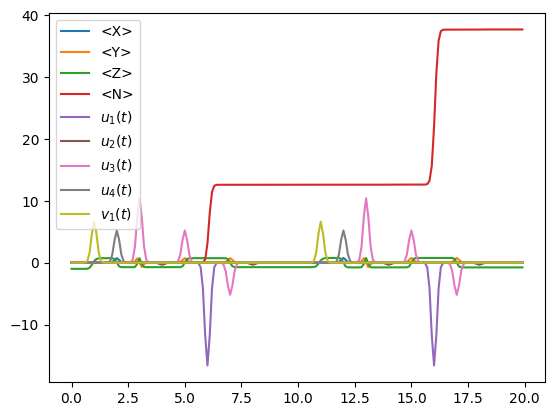

In [58]:
figpre, axpre = plt.subplots()
sbs.plot(
    ax=axpre,
    exp_ops=[IX,IY,IZ,NI],
    exp_names=["<X>","<Y>","<Z>","<N>"]
)
axpre.legend()
figpre.show()

In [59]:
rho_t = sbs.run()
rho_res_t = dq.ptrace(rho_t,0,(N,2))
rho_qub_t = dq.ptrace(rho_t,1,(N,2))

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


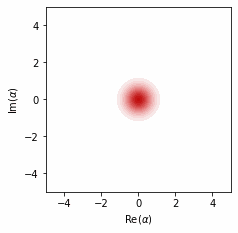

In [60]:
dq.plot.wigner_gif(rho_res_t)